In [1]:
# Imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy

import os
import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune

from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle, Aggregator
from src.algorithms.rl import EnergyCommunityMultiHouseholdsEnv_v0
from src.utils.plotting import households_plots

In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Define resources

resources = []

# Add the aggregator, prices are shared across households
aggregator = Aggregator(name='aggregator_1',
                        imports=np.zeros(data.peers['buy_price'][0].shape),
                        exports=np.zeros(data.peers['buy_price'][0].shape),
                        import_max=data.peers['import_contracted_p_max'][0],
                        export_max=data.peers['export_contracted_p_max'][0],
                        import_cost=data.peers['buy_price'][0],
                        export_cost=data.peers['sell_price'][0]
                        )

max_timesteps = aggregator.imports.shape[0]
# Generate the households
# For simplicity, we assume there are as many households as there are loads
for i in range(data.load['p_forecast'].shape[0]):
    household_resources = {}
    # Add the loads
    household_resources['load']=Load(name='load_{:02d}'.format(i + 1),
                                    value=data.load['p_forecast'][i],
                                    cost_cut=data.load['cost_cut'][i],
                                    cost_reduce=data.load['cost_reduce'][i],
                                    cost_ens=data.load['cost_ens'][i])

    # Add the generators
    household_resources['generator'] = Generator(name='generator_{:02d}'.format(i + 1),
                                         value=np.zeros(data.generator['p_forecast'][0].shape),
                                         lower_bound=np.zeros(data.generator['p_forecast'].shape),
                                         upper_bound=data.generator['p_forecast'][i],
                                         cost=data.generator['cost_parameter_b'][i],
                                         cost_nde=data.generator['cost_nde'][i],
                                         is_renewable=data.generator['type_generator'][i])

    # Add the storage
    if i < data.storage['p_charge_limit'].shape[0]:
        household_resources['storage']=(Storage(name='storage_{:02d}'.format(i + 1),
                                           value=np.zeros(data.storage['p_charge_limit'][0].shape),
                                           cost_discharge=data.storage['discharge_price'][i],
                                           cost_charge=data.storage['charge_price'][i],
                                           capacity_max=data.storage['energy_capacity'][i],
                                           capacity_min=0,
                                           initial_charge=data.storage['initial_state'][i],
                                           discharge_efficiency=data.storage['discharge_efficiency'][i],
                                           charge_efficiency=data.storage['charge_efficiency'][i],
                                           discharge_max=data.storage['p_discharge_max'][i],
                                           charge_max=data.storage['p_charge_max'][i],
                                           capital_cost=0))

    household_resources['aggregator'] = deepcopy(aggregator)
    resources.append(household_resources)


In [4]:
# Create the environment and check if everything is ok
import_penalty = 5000
export_penalty = 5000
storage_action_reward = 0
storage_action_penalty = 5000
balance_penalty = 0
# TODO: Take costs from the excel file
temp_env = EnergyCommunityMultiHouseholdsEnv_v0(households_resources=resources, import_penalty=import_penalty,
                                                export_penalty=export_penalty,
                                                storage_action_penalty=storage_action_penalty,
                                                storage_action_reward=storage_action_reward,
                                                balance_penalty=balance_penalty,
                                                max_timesteps=max_timesteps)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.households}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
    # print('Observation: {}'.format(observations))
    # print('Observation keys: {}'.format(observations.keys()))
    print('Reward: {}'.format(rewards))
    # print('Infos: {}\n'.format(infos))
print('Terminated: {}'.format(terminations['__all__']))

Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}
Reward: {}


KeyError: '__common__'

In [ ]:
# Aux function to assign policies

def assign_policies(env):
    policies = {}
    for household_id in env.households:
        policies[str(household_id)] = (None,
                           env.observation_space[household_id],
                           env.action_space[household_id],
                           {})
    return policies


policies = assign_policies(env=temp_env)

In [ ]:
from ray.tune import register_env

# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

ray.shutdown()
ray.init()
run_env = EnergyCommunityMultiHouseholdsEnv_v0(households_resources=resources,
                                                                             import_penalty=import_penalty,
                                                                             export_penalty=export_penalty,
                                                                             storage_action_penalty=storage_action_penalty,
                                                                             storage_action_reward=storage_action_reward,
                                                                             balance_penalty=balance_penalty,
                                                                             max_timesteps=max_timesteps)
register_env("EC_Multi", lambda config: run_env)

config = (
    PPOConfig()
    .environment(env="EC_Multi")
    .training(
        train_batch_size=240,
        lr=2e-4,
        gamma=0.99)
    # entropy_coeff=0.05,
    # kl_coeff=0.0)
    .framework('torch')  # 'tf2', eager_tracing=False)
    .rollouts(num_rollout_workers=10, rollout_fragment_length=24)
    .multi_agent(policies=policies,
                 policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: str(agent_id))
)
# Use the config's `build()` method to construct a PPO object.
algo = config.build()

# Train for n iterations and report results (mean episode rewards).
# Since we have to guess 10 times and the optimal reward is 0.0
# (exact match between observation and action value),
# we can expect to reach an optimal episode reward of 0.0.
checkpoint = None
for i in range(3):
    results = algo.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    if results['episode_reward_mean'] > -50.0:
        break

    # Save the checkpoint to disk.
    checkpoint = algo.save()
    # print("checkpoints saved at", checkpoint)

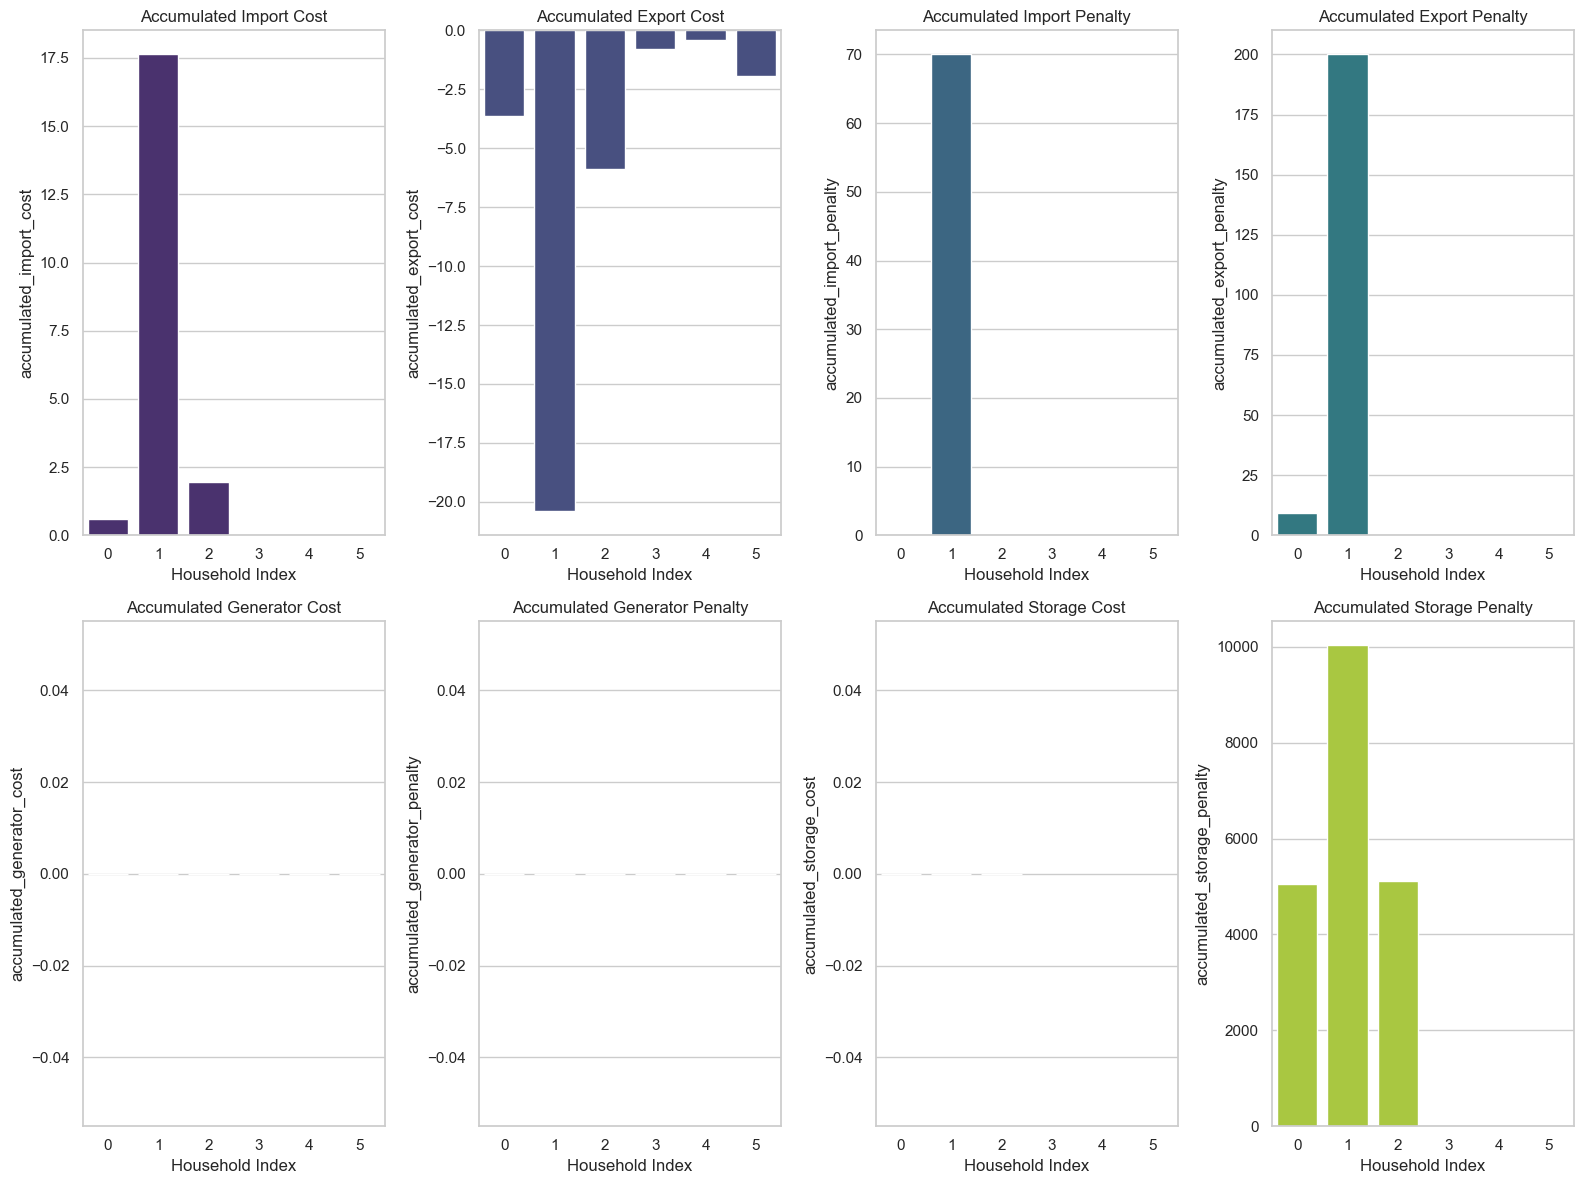

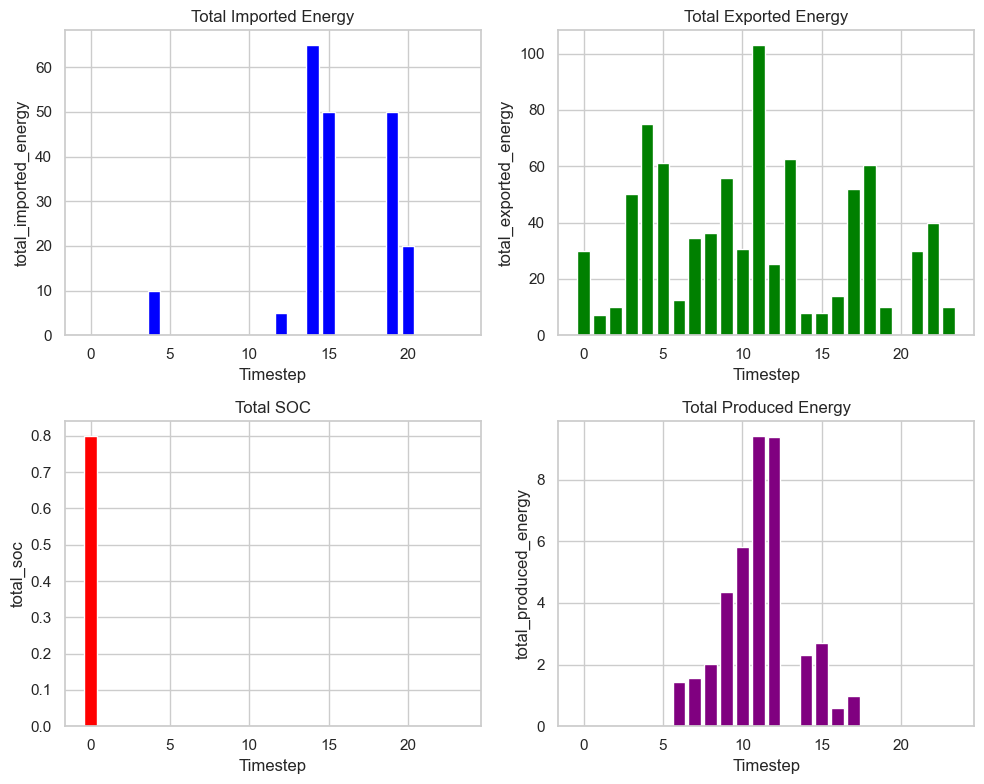

In [5]:
# Try reading and plotting some saved results

pd_per_timestep_logs = pd.read_csv('results/run_results_2024-05-29_02-23-46/aggregated_results.csv')
pd_per_household_logs = pd.read_csv('results/run_results_2024-05-29_02-23-46/accumulated_household_logs.csv')
households_plots.plot_per_household_logs(pd_per_household_logs)
households_plots.plot_per_timestep_logs(pd_per_timestep_logs)


In [11]:
print(results['info'])

{'learner': {'2': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.1602941537896792, 'cur_kl_coeff': 0.3000000000000001, 'cur_lr': 0.00020000000000000006, 'total_loss': 9.272882334391277, 'policy_loss': -0.028678646903911916, 'vf_loss': 9.29598782857259, 'vf_explained_var': 0.0, 'kl': 0.018577102248673327, 'entropy': 3.1413570364316303, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 120.0, 'num_grad_updates_lifetime': 150.5, 'diff_num_grad_updates_vs_sampler_policy': 29.5}, '5': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 4.216883444786072, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00020000000000000006, 'total_loss': 0.5476969455679258, 'policy_loss': -0.06533034999544422, 'vf_loss': 0.595736688375473, 'vf_explained_var': 0.23356647888819376, 'kl': 0.03842356836733719, 'entropy': 3.8799327969551087, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 120.0, 'num_grad_updates_lifetim

In [9]:
algo.get_state()

{'iteration': 20,
 'timesteps_total': None,
 'time_total': 71.17653465270996,
 'episodes_total': 190,
 'last_result': {'custom_metrics': {},
  'episode_media': {},
  'info': {'learner': {'2': {'learner_stats': {'allreduce_latency': 0.0,
      'grad_gnorm': 1.6072334080934525,
      'cur_kl_coeff': 0.7593750000000001,
      'cur_lr': 0.00020000000000000006,
      'total_loss': 6.859228324890137,
      'policy_loss': -0.03356546958287557,
      'vf_loss': 6.883545589447022,
      'vf_explained_var': -2.22325325012207e-06,
      'kl': 0.012178834398218897,
      'entropy': 2.0924310167630513,
      'entropy_coeff': 0.0},
     'model': {},
     'custom_metrics': {},
     'num_agent_steps_trained': 120.0,
     'num_grad_updates_lifetime': 1170.5,
     'diff_num_grad_updates_vs_sampler_policy': 29.5},
    '4': {'learner_stats': {'allreduce_latency': 0.0,
      'grad_gnorm': 1.7638625343640646,
      'cur_kl_coeff': 1.0125000000000004,
      'cur_lr': 0.00020000000000000006,
      'total_loss

In [12]:
print(run_env.final_logs)

{}


In [13]:
print(results)

{'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'3': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.6330956747134526, 'cur_kl_coeff': 0.42714843750000014, 'cur_lr': 0.00020000000000000006, 'total_loss': 0.0726798781446026, 'policy_loss': -0.005388709735901405, 'vf_loss': 0.07574741064260403, 'vf_explained_var': 0.22685865064462027, 'kl': 0.005434127669286681, 'entropy': 2.413917370637258, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 120.0, 'num_grad_updates_lifetime': 5430.5, 'diff_num_grad_updates_vs_sampler_policy': 29.5}, '2': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 2.280141690870126, 'cur_kl_coeff': 0.17105230093002324, 'cur_lr': 0.00020000000000000006, 'total_loss': 6.2662955602010095, 'policy_loss': -0.010461809191648777, 'vf_loss': 6.272536436716716, 'vf_explained_var': 0.035218591491381325, 'kl': 0.024675651859433857, 'entropy': 1.6336575706799825, 'entropy_coeff': 0.0}, 'model': {}, 'cust

In [ ]:
# Check the actions (inference)

temp_env = EnergyCommunityMultiEnv_v0(resources)
obs, info = temp_env.reset()
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
episode_info = []
while not terminations['__all__'] and not truncations['__all__']:
    print('Timestep: {}'.format(temp_env.current_timestep))
    action_dict = {a: algo.compute_single_action(observation=obs[a], policy_id=a) for a in temp_env.agents}
    #action_dict = {'producer': algo.compute_single_action(observation=obs['producer'], policy_id='pol_producer'),
    #               'consumer': algo.compute_single_action(observation=obs['consumer'], policy_id='pol_consumer')}
    obs, reward, terminations, truncations, info = temp_env.step(action_dict)
    episode_info.append(info)
    #total_reward_prod += reward['producer']
    #total_reward_cons += reward['consumer']
    #print(f"Producer Action: {action_dict['producer']}; reward: {reward['producer']}; total reward: {total_reward_prod}")
    #print(f"Consumer Action: {action_dict['consumer']}; reward: {reward['consumer']}; total reward: {total_reward_cons}")

In [ ]:
episode_info

[]

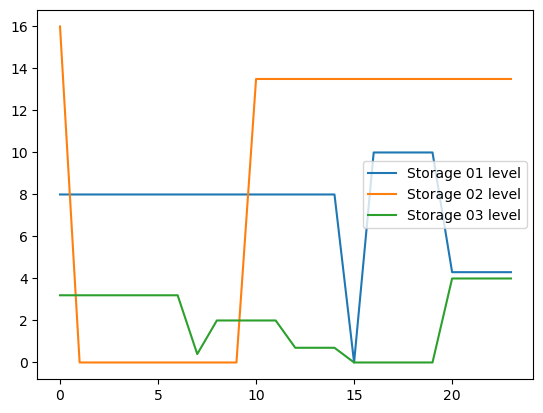

In [13]:
# Plot the storage

for s in range(1, 4):
    temp_storage = [episode_info[i]['storage_{:02d}'.format(s)]['current']
                    for i in range(len(episode_info) - 1)]
    plt.plot(temp_storage,
             label='Storage {:02d} level'.format(s))

plt.legend()
plt.plot()

[]

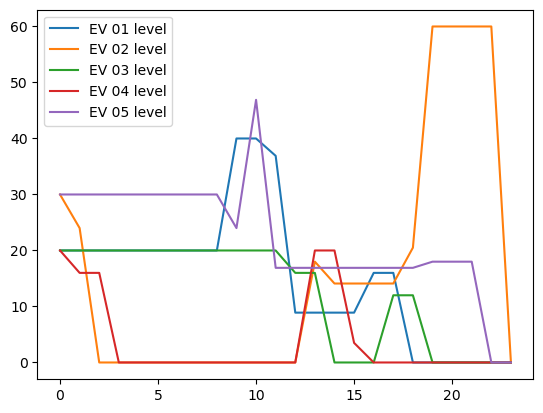

In [14]:
# Plot the EVs

for e in range(1, 6):
    temp_ev = [episode_info[i]['ev_{:02d}'.format(e)]['current']
               for i in range(len(episode_info) - 1)]
    plt.plot(temp_ev,
             label='EV {:02d} level'.format(e))

plt.legend()
plt.plot()

In [15]:
import torch

torch.device('cuda')

device(type='cuda')

In [19]:
torch.cuda.is_available()

False

In [17]:
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [18]:
import torch

print("Torch version:", torch.__version__)

print("Is CUDA enabled?", torch.cuda.is_available())

Torch version: 2.2.2+cpu
Is CUDA enabled? False
